In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import itertools
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
import backtrader as bt
import pyfolio as pf

### Parameters

In [3]:
ticker = 'CELG'
days=[5, 20]
return_days = 3
extreme = 3
test_date_start = datetime(2013,1,1)
test_date = test_date_start.strftime('%Y-%m-%d')
test_date_end = datetime(2017,1,1)
filename = '{}_{}_{}.h5py'.format(ticker, return_days, extreme)

In [4]:
aal = pdr.get_data_google(ticker, '2000-01-01', '2017-01-01')

In [5]:
aal.drop('Volume', axis=1, inplace=True)
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-06,3.12,3.50,3.12,3.45
2001-02-07,3.41,3.45,3.16,3.35
2001-02-08,3.38,3.38,3.22,3.32
2001-02-09,3.31,3.34,3.21,3.30
2001-02-12,3.34,3.56,3.31,3.43


In [6]:
def _set_index_column_if_necessary(data: pd.DataFrame) -> pd.DataFrame:
    if 'Date' in data.columns:
        data.set_index('Date', inplace=True)
    return data

In [7]:
aal = _set_index_column_if_necessary(aal)
cols = aal.columns
aal.head()

,Open,High,Low,Close
Date,,,,
2001-02-06,3.12,3.50,3.12,3.45
2001-02-07,3.41,3.45,3.16,3.35
2001-02-08,3.38,3.38,3.22,3.32
2001-02-09,3.31,3.34,3.21,3.30
2001-02-12,3.34,3.56,3.31,3.43


In [8]:
cols

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [9]:
def feature(data, first_col, second_col):
    return data[first_col]/data[second_col]

In [10]:
def create_extra_columns(data, cols):
    pool = []
    for left, right in itertools.product(cols, cols):
        pair1 = left + right
        pair2 = right + left
        if left != right and pair1 not in pool and pair2 not in pool:
            aal[left + '/' + right] = feature(data, left, right)
            pool.append(pair1)

### Rolling features

In [11]:
for col, day in itertools.product(cols, days):
    aal[col + ' ' + str(day) + ' MA'] = aal[col].rolling(day).mean()
    aal[col + ' ' + str(day) + ' max'] = aal[col].rolling(day).max()
    aal[col + ' ' + str(day) + ' min'] = aal[col].rolling(day).min()
aal.dropna(inplace=True)

In [12]:
aal.columns

Index(['Open', 'High', 'Low', 'Close', 'Open 5 MA', 'Open 5 max', 'Open 5 min',
       'Open 20 MA', 'Open 20 max', 'Open 20 min', 'High 5 MA', 'High 5 max',
       'High 5 min', 'High 20 MA', 'High 20 max', 'High 20 min', 'Low 5 MA',
       'Low 5 max', 'Low 5 min', 'Low 20 MA', 'Low 20 max', 'Low 20 min',
       'Close 5 MA', 'Close 5 max', 'Close 5 min', 'Close 20 MA',
       'Close 20 max', 'Close 20 min'],
      dtype='object')

In [13]:
plain_features = list(filter(lambda col: '/' not in col, aal.columns))

In [14]:
create_extra_columns(aal, plain_features)

In [15]:
ret = 100*aal['Close'].pct_change(return_days).shift(-return_days)

In [16]:
# ret_dev = ret.rolling(10).std().fillna(1)

# ret_scaled = ret/ret_dev
# ret_scaled.head()

In [17]:
features_to_drop = list(filter(lambda col: '/' not in col, aal.columns))
aal.drop(features_to_drop, axis=1, inplace=True)

aal['Return'] = ret # ret_scaled
aal.head(10)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min,Return
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-06,0.933140,1.000000,0.981651,0.986478,0.949704,1.000000,0.976723,0.909348,1.146429,0.951957,...,1.008505,0.962319,1.106667,0.959903,0.915942,1.053333,0.954203,1.097333,1.150000,-6.727829
2001-03-07,0.994083,1.021277,1.005988,1.024390,0.994083,1.046729,1.018645,0.951841,1.200000,0.998217,...,1.016279,0.968116,1.113333,0.961509,0.915942,1.053333,0.952609,1.095500,1.150000,-19.161677
2001-03-08,0.954286,1.080906,1.080906,1.010896,0.988166,1.040498,1.013657,0.946176,1.192857,0.976608,...,1.020315,0.968116,1.113333,0.943944,0.895652,1.030000,0.948841,1.091167,1.150000,-11.650485
2001-03-09,0.962382,1.040678,1.006557,0.938264,0.908284,1.000000,0.936118,0.869688,1.096429,0.908822,...,1.024540,0.968116,1.113333,0.935583,0.884058,1.016667,0.944928,1.086667,1.150000,-10.491803
2001-03-12,0.989899,1.126437,1.088889,0.923367,0.875000,1.000000,0.901564,0.832861,1.050000,0.891990,...,1.034056,0.968116,1.237037,0.835913,0.782609,1.000000,0.936232,1.196296,1.277778,0.000000
2001-03-13,0.971731,1.049618,1.007326,0.889392,0.818452,1.000000,0.850998,0.779037,1.000000,0.866415,...,1.045383,0.968116,1.237037,0.845070,0.782609,1.000000,0.926087,1.183333,1.277778,-14.285714
2001-03-14,0.921429,1.011765,0.945055,0.878747,0.772455,1.000000,0.810302,0.732955,1.000000,0.843689,...,0.976458,0.895652,1.144444,0.853215,0.782609,1.000000,0.917246,1.172037,1.277778,-5.860806
2001-03-15,0.982143,1.018519,1.018519,0.975869,0.895765,1.065891,0.871632,0.781250,1.065891,0.942426,...,0.975376,0.902367,1.129630,0.863447,0.798817,1.000000,0.925148,1.158148,1.251852,-7.037037
2001-03-16,0.988848,1.141631,1.136752,0.972222,0.904762,1.031008,0.854756,0.786982,1.031008,0.943932,...,0.887805,0.812500,1.166667,0.760976,0.696429,1.000000,0.915179,1.314103,1.435897,4.273504


In [18]:
len(aal.columns)

379

In [19]:
list(aal.columns)[:5]

['Open/High', 'Open/Low', 'Open/Close', 'Open/Open 5 MA', 'Open/Open 5 max']

# X/y spit

In [20]:
aal.dropna(inplace=True)
aal.replace([np.inf, -np.inf], 1, inplace=True)
X_data = aal.drop('Return', axis=1)
y_data = aal['Return']

In [21]:
X_data.head(2)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 5 min,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min
Date,,,,,,,,,,,,,,,,,,,,,
2001-03-06,0.933140,1.000000,0.981651,0.986478,0.949704,1.000000,0.976723,0.909348,1.146429,0.951957,...,1.050633,1.008505,0.962319,1.106667,0.959903,0.915942,1.053333,0.954203,1.097333,1.15
2001-03-07,0.994083,1.021277,1.005988,1.024390,0.994083,1.046729,1.018645,0.951841,1.200000,0.998217,...,1.056962,1.016279,0.968116,1.113333,0.961509,0.915942,1.053333,0.952609,1.095500,1.15


In [22]:
y_data.head(2)

Date
2001-03-06    -6.727829
2001-03-07   -19.161677
Name: Return, dtype: float64

In [23]:
def series_to_binarized_columns(y):
    pos = y > extreme
    neg = y < -extreme
    meds = (y > -extreme) & (y < extreme)
    y = np.array([neg, meds, pos]).T
    return y

In [24]:
X_train = X_data[:test_date]
X_test = X_data[test_date:]
y_train = y_data[:test_date]
y_test = y_data[test_date:]

In [25]:
y_train = series_to_binarized_columns(y_train)
y_test = series_to_binarized_columns(y_test)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [27]:
X_test_df = X_test.copy()
X_test = scaler.transform(X_test)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns, index=X_test_df.index)

In [28]:
X_test_df.head(1)

,Open/High,Open/Low,Open/Close,Open/Open 5 MA,Open/Open 5 max,Open/Open 5 min,Open/Open 20 MA,Open/Open 20 max,Open/Open 20 min,Open/High 5 MA,...,Close 5 max/Close 5 min,Close 5 max/Close 20 MA,Close 5 max/Close 20 max,Close 5 max/Close 20 min,Close 5 min/Close 20 MA,Close 5 min/Close 20 max,Close 5 min/Close 20 min,Close 20 MA/Close 20 max,Close 20 MA/Close 20 min,Close 20 max/Close 20 min
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.305932,-0.697925,-0.469245,0.528119,0.750331,-0.022969,-0.031212,0.606253,-0.631687,0.835794,...,-0.297708,-0.290138,0.476754,-0.768619,-0.070545,0.516564,-0.754882,0.984723,-1.013084,-0.99204


# KERAS

In [29]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LSTM
from keras.optimizers import Adam, RMSprop
from keras.models import load_model

Using TensorFlow backend.


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

In [31]:
def expand(X, axis=1):
    return np.expand_dims(X, axis=axis)

In [32]:
temp_y = np.argmax(y_train, axis=1)
cw = class_weight.compute_class_weight('balanced', np.unique(temp_y), temp_y)
cw

array([ 1.80839416,  0.57019563,  1.44250364])

In [33]:
input_shape = (1, 1, X_train.shape[1])
input_shape

(1, 1, 378)

In [37]:
def build_and_run():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, batch_input_shape=input_shape, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='glorot_uniform'))
    model.add(Activation('softmax'))

    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    for i in range(30):
        print(f'Iteration {i}')
        model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=5, shuffle=False, verbose=2)
        model.reset_states()
    model.save(filename)
    return model

In [38]:
#model.fit(expand(X_train), y_train, class_weight=cw, batch_size=1, epochs=100, shuffle=False, verbose=2) # , validation_data=(expand(X_test), y_test)

In [39]:
try:
    model = load_model(filename)
except:
    model = build_and_run()

Iteration 0
Epoch 1/5
 - 13s - loss: 0.9536 - acc: 0.5718
Epoch 2/5
 - 11s - loss: 0.9386 - acc: 0.5732
Epoch 3/5
 - 11s - loss: 0.9301 - acc: 0.5735
Epoch 4/5
 - 12s - loss: 0.9302 - acc: 0.5721
Epoch 5/5
 - 11s - loss: 0.9234 - acc: 0.5873
Iteration 1
Epoch 1/5
 - 13s - loss: 0.9243 - acc: 0.5839
Epoch 2/5
 - 14s - loss: 0.9199 - acc: 0.5876
Epoch 3/5
 - 13s - loss: 0.9098 - acc: 0.6017
Epoch 4/5
 - 12s - loss: 0.9102 - acc: 0.6001
Epoch 5/5
 - 14s - loss: 0.9057 - acc: 0.6024
Iteration 2
Epoch 1/5
 - 14s - loss: 0.9012 - acc: 0.6011
Epoch 2/5
 - 13s - loss: 0.8994 - acc: 0.5987
Epoch 3/5
 - 13s - loss: 0.8863 - acc: 0.6028
Epoch 4/5
 - 12s - loss: 0.8926 - acc: 0.6078
Epoch 5/5
 - 13s - loss: 0.8872 - acc: 0.6065
Iteration 3
Epoch 1/5
 - 12s - loss: 0.8876 - acc: 0.6118
Epoch 2/5
 - 13s - loss: 0.8760 - acc: 0.6206
Epoch 3/5
 - 12s - loss: 0.8712 - acc: 0.6182
Epoch 4/5
 - 13s - loss: 0.8690 - acc: 0.6182
Epoch 5/5
 - 12s - loss: 0.8643 - acc: 0.6165
Iteration 4
Epoch 1/5
 - 13s - l

In [40]:
class ModelEvaluator:
    def __init__(self,
                 model):
        self.model = model

    def evaluate(self, X, y, ret):
        all_returns = []
        for c in [0.34 + x/50 for x in range(35)]:
            print('=================')
            print(f'Certainty is {c}')
            returns = self.calculate_returns(X, y, ret, c)
            cont = self.print_returns_distribution(returns)
            if not cont:
                break

    def calculate_returns(self, X, y, ret, certainty):
        predicted = self.model.predict(expand(X), batch_size=1)
        real_ups = y[:, 2]
        real_downs = y[:, 0]
        predicted_ups = (predicted[:, 2] > certainty)# & (np.argmax(predicted, axis=1) == 2)
        predicted_downs = (predicted[:, 0] > certainty)# & (np.argmax(predicted, axis=1) == 0)
        returns = np.append(ret[predicted_ups],
                            (-1 * ret[predicted_downs]))

        print('Real ups count: {}'.format(pd.value_counts(real_ups[predicted_ups])))
        print('Real downs count: {}'.format(pd.value_counts(real_downs[predicted_downs])))
        return returns

    def print_returns_distribution(self, returns):
        lose = np.sum(returns[returns < 0])
        win = np.sum(returns[returns > 0])
        if lose == 0 and win == 0:
            return False
        print('Negative returns:', str(lose))
        print('Positive returns:', str(win))
        print('Pos/Neg ratio:', str(win / (lose * -1)))
        print('Sum of returns:', str(np.sum(returns)))
        return True

In [41]:
evaluator = ModelEvaluator(model)
evaluator.evaluate(X_test, y_test, y_data[test_date:]) # [:988]

Certainty is 0.34
Real ups count: False    152
True      32
dtype: int64
Real downs count: False    21
True      8
dtype: int64
Negative returns: -261.956469704
Positive returns: 301.851074503
Pos/Neg ratio: 1.15229478716
Sum of returns: 39.8946047984
Certainty is 0.36000000000000004
Real ups count: False    142
True      30
dtype: int64
Real downs count: False    17
True      7
dtype: int64
Negative returns: -231.294404323
Positive returns: 274.439379546
Pos/Neg ratio: 1.18653704723
Sum of returns: 43.1449752231
Certainty is 0.38
Real ups count: False    133
True      26
dtype: int64
Real downs count: False    12
True      7
dtype: int64
Negative returns: -198.322969719
Positive returns: 244.656068261
Pos/Neg ratio: 1.23362446926
Sum of returns: 46.3330985421
Certainty is 0.4
Real ups count: False    120
True      24
dtype: int64
Real downs count: False    9
True     6
dtype: int64
Negative returns: -179.428039583
Positive returns: 218.817895358
Pos/Neg ratio: 1.21953010168
Sum of ret

# Backtest

In [48]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.certainty = 0.62
        self.dataclose = self.datas[0].close
        self.orders = {}
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
    def entries_to_remove(entries, the_dict):
        for key in entries:
            if key in the_dict:
                del the_dict[key]

    def next(self):
        if not self.position:
            try:
                today = self.datas[0].datetime.date(1).isoformat()
                data_row = X_test_df.loc[today]
                prediction = model.predict(expand(expand(data_row,0),0))[0]
                if prediction[2] > self.certainty:
                    self.log(f'Predict long for {today}')
                    self.orders[len(self)] = self.buy(exectype=bt.Order.Close)
                elif prediction[0] > self.certainty:
                    self.log(f'Predict short for {today}')
                    self.orders[len(self)] = self.sell(exectype=bt.Order.Close)
            except Exception as e:
                self.log(e)
        
        old_entries = []
        for days, order_on_days in self.orders.items():
            if len(self) > days + return_days:
                old_entries.append(days)
                if order_on_days.isbuy():
                    self.log('closing the long position')
                    self.sell(exectype=bt.Order.Close)
                else:
                    self.log('closing the short position')
                    self.buy(exectype=bt.Order.Close)
        TestStrategy.entries_to_remove(old_entries, self.orders)

In [49]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)

data = bt.feeds.YahooFinanceData(
    dataname=ticker,
    fromdate=test_date_start,
    todate=test_date_end,
    reverse=False)

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

Starting Portfolio Value: 100000.00
2013-04-24, Predict long for 2013-04-25
2013-04-25, BUY EXECUTED, 58.97
2013-04-30, closing the long position
2013-05-01, SELL EXECUTED, 58.33
2013-05-01, Predict long for 2013-05-02
2013-05-02, BUY EXECUTED, 59.63
2013-05-07, closing the long position
2013-05-08, SELL EXECUTED, 61.37
2013-05-16, Predict long for 2013-05-17
2013-05-17, BUY EXECUTED, 62.46
2013-05-22, closing the long position
2013-05-23, SELL EXECUTED, 61.82
2013-06-28, Predict long for 2013-07-01
2013-07-01, BUY EXECUTED, 59.46
2013-07-05, closing the long position
2013-07-08, SELL EXECUTED, 60.97
2013-08-12, Predict long for 2013-08-13
2013-08-13, BUY EXECUTED, 68.82
2013-08-16, closing the long position
2013-08-19, SELL EXECUTED, 66.22
2013-08-19, Predict long for 2013-08-20
2013-08-20, BUY EXECUTED, 67.87
2013-08-23, closing the long position
2013-08-26, SELL EXECUTED, 70.58
2013-12-16, Predict long for 2013-12-17
2013-12-17, BUY EXECUTED, 80.39
2013-12-20, closing the long posit

Entire data start date: 2013-01-02
Entire data end date: 2016-12-30
Backtest months: 48


,Backtest
Annual return,3.4%
Cumulative returns,14.3%
Annual volatility,6.9%
Sharpe ratio,0.52
Calmar ratio,0.47
Stability,0.81
Max drawdown,-7.3%
Omega ratio,1.23
Sortino ratio,0.82
Skew,1.63


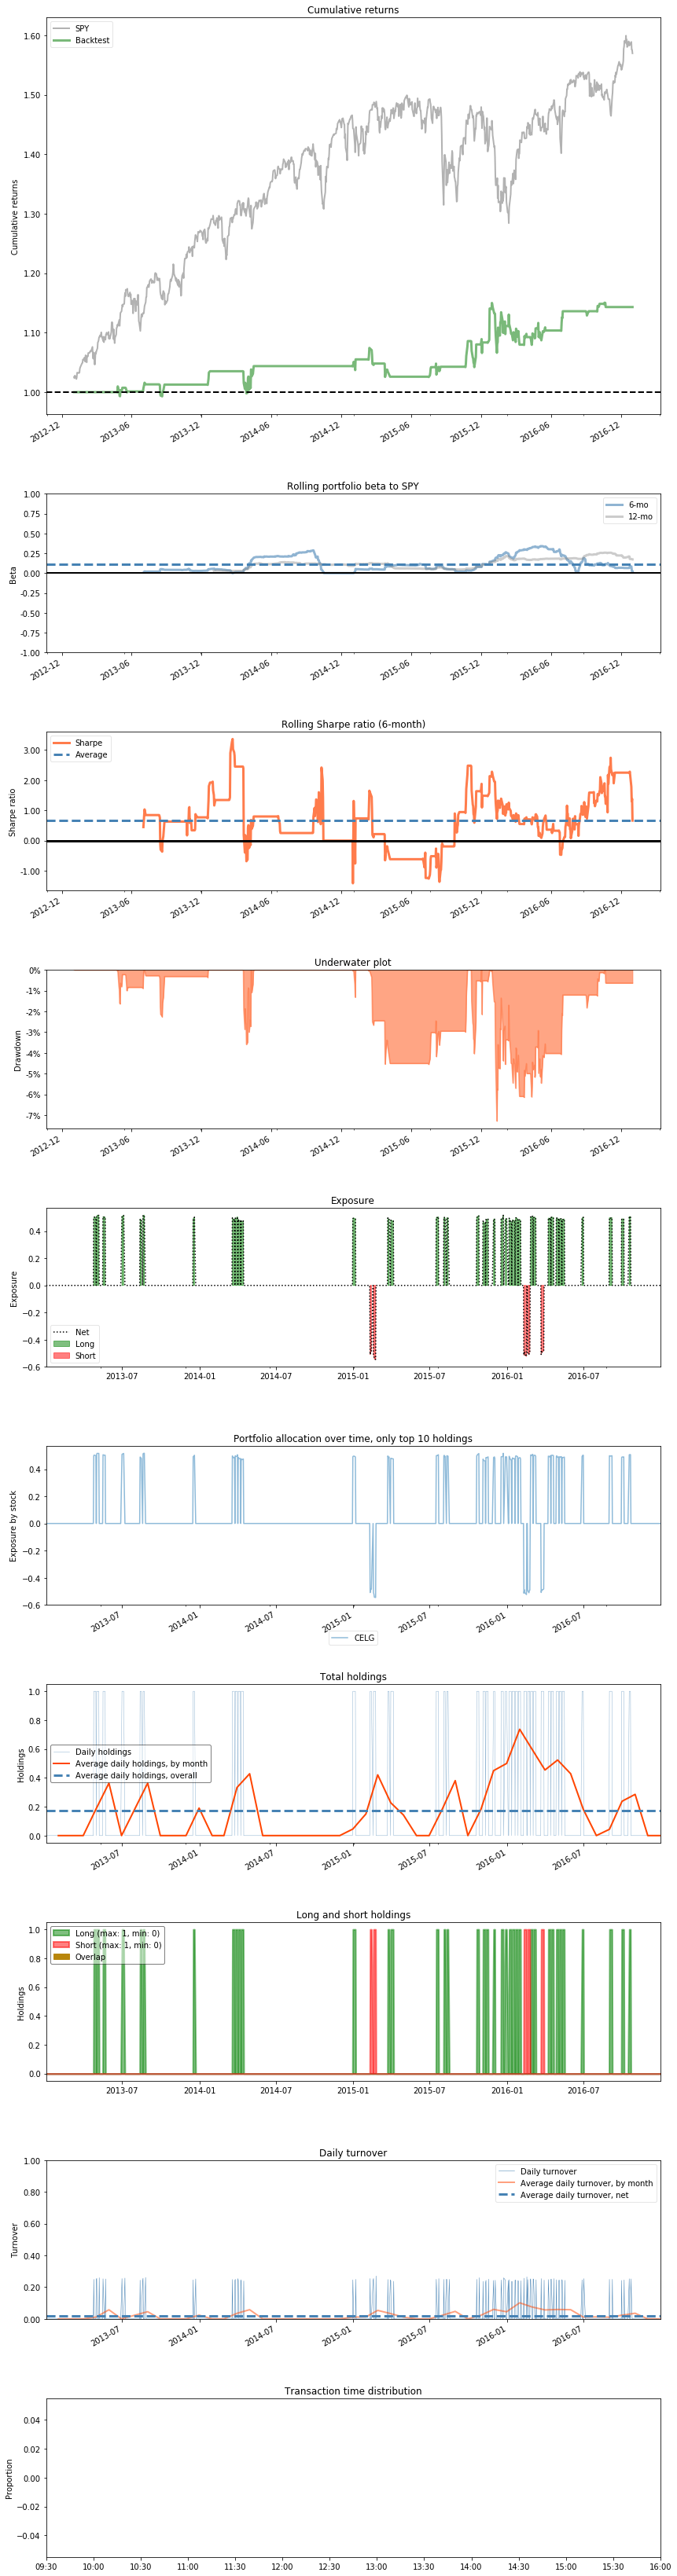

In [50]:
pf.create_simple_tear_sheet(returns=returns, 
                          positions=positions, 
                          transactions=transactions)